In [77]:
include("../src/HPFEM.jl")

HPFEM

In [100]:
nel = 1
nnodes = nel + 1
idir = [1,nnodes]
M = 5
Q = M+2
bas = HPFEM.Basis1d(M,Q)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);

In [110]:
a = 0.0
b = π
nodes = collect(linspace(a, b, nnodes))

2-element Array{Float64,1}:
 0.0    
 3.14159

In [111]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [112]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBMatrix);

In [113]:
for e = 1:nel
    Ae = HPFEM.mass_matrix(bas, elems[e])
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [114]:
Fe = zeros(HPFEM.nmodes(lmap), nel)

for e = 1:nel
    fe = cos(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
Fe[1,1] = cos(a)
Fe[2,nel] = cos(b)
Fe


5x1 Array{Float64,2}:
  1.0        
 -1.0        
  6.93889e-18
 -0.274834   
 -2.08167e-17

In [115]:
HPFEM.solve!(solver, Fe)

5x1 Array{Float64,2}:
  1.0    
 -6.76518
 16.1425 
 12.4962 
  8.07125

In [116]:
ξ = collect(linspace(-1,1,101));
nq = length(ξ)
fun = zeros(nq, nel)
for e = 1:nel
    for k = 1:M
        for q = 1:nq
            fun[q,e] += Fe[k,e] * bas(ξ[q], k)
        end
    end
end



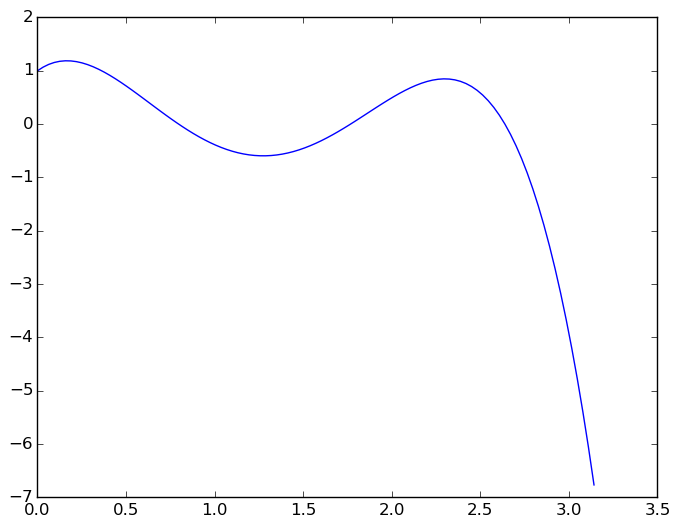

In [117]:
using PyPlot

for e = 1:nel
    el = elems[e]
    x = (1-ξ)*el.a/2 + (1+ξ)*el.b/2
    
    plot(x, fun[:,e])
end